In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Update path to import from Drive.
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/clustering/src')

!pip install pymysql
!pip install -U scikit-learn

from prepare import wrangle_zillow, calc_vif, plot_corr

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scs

lucario = ['#6EA4BB', '#C04C4B', '#464646', '#E7E7E6', '#F0DBA5']
puff = ['#008393', '#E3ABB5', '#040405', '#F5D9E2']
sns.set_palette(sns.color_palette(lucario))

from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_regression


In [ ]:
X_train, X_test, X_val, y_train, y_test, y_val = wrangle_zillow(test_size=.15, k=20)


Missing values in ['delinquet', 'poolcnt', 'heating', 'regionidcity'] replaced with zeros

Missing values in ['buildquality', 'lotsqft'] replaced with median

These columns were dropped.
Empty DataFrame
Columns: [missing count, missing %]
Index: []

353 incomplete cases dropped from the data.

215 outliers dropped based on ['logerror'].

X_train (50087, 99), X_test (10734, 99), X_val (10733, 99)
y_train (50087,), y_test (10734,), y_val (10733,)


## Agenda

## TL;DR

Follow outline order and add nothing new. Justify, conclude, recommend.

Logerror is ...


Root Mean Squared Logarithmic Error (RMSLE) is an extension on [Mean Squared Error (MSE) that is mainly used when **predictions have large deviations.** Values range from 0 to millions and we don't want to punish deviations in prediction as much as with MSE.

Root Mean Squared Log Error (RMSLE) can be defined using a slight modification on sklearn's mean_squared_log_error function. The formula for RMSLE is represented as follows:

RMSLE = $\sqrt{\frac{1}{n} \sum_{i=1}^n (\log(p_i + 1) - \log(a_i+1))^2 }$

Where:

$n$ is the total number of observations in the (public/private) data set,

$p_i$ is your prediction of target, and

$a_i$ is the actual target for $i$.

$log(x)$ is the natural logarithm of $x$ ($log_e(x)$.

Making a constant prediction is a good way to get a sense of what it means to have good performance on model. You can build a complex model that can get 95% accuracy, but if a constant prediction will give you that as well than 95% doesn't look so good anymore. A metric like [AUC (Area under ROC Curve) gives a more honest representation for constant predictions, which is 0.5 and the same for random predictions.

#### Best constant for RMSLE = $\mathrm{e}^{mean(log_e(targets))}$



In [ ]:
X_train.head()

,bathroomcnt,bedroomcnt,poolcnt,buildquality,regionidcity,finishedsqft,latitude,longitude,structuretaxvalue,delinquet,taxvalue,landtaxvalue,taxamount,livingarearatio,buildinglandvalueratio,taxrate,age,age_bins,acres,sqftvalue,landsqftvalue,Los Angeles,Orange,Ventura,Central,Floor,Forced air,Solar,95984.0,95989.0,96006.0,96007.0,96020.0,96022.0,96026.0,96038.0,96043.0,96046.0,96047.0,96049.0,...,96238.0,96244.0,96245.0,96246.0,96280.0,96293.0,96294.0,96325.0,96326.0,96336.0,96338.0,96339.0,96342.0,96368.0,96379.0,96387.0,96415.0,96426.0,96437.0,96465.0,96467.0,96475.0,96492.0,96508.0,96513.0,96517.0,96939.0,96946.0,96951.0,96962.0,96975.0,96981.0,96985.0,97018.0,97023.0,97026.0,97068.0,97111.0,97113.0,97298.0
parcelid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12566099,1.0,3.0,0.0,4.0,46298.0,1015.0,33.868232,-118.196184,84468.0,0.0,345184.0,260716.0,4249.92,0.156130,0.323985,0.012312,73.0,1,0.149242,83.219704,40.103984,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
14471109,3.0,3.0,0.0,6.0,12773.0,2340.0,33.575620,-117.645998,247679.0,0.0,404651.0,156972.0,4009.14,0.468000,1.577855,0.009908,27.0,0,0.114784,105.845726,31.394400,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12322197,1.0,2.0,0.0,4.0,47762.0,862.0,33.914780,-118.169196,94855.0,0.0,254647.0,159792.0,3598.17,0.135962,0.593615,0.014130,69.0,1,0.145546,110.040603,25.203785,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
14116975,2.0,3.0,0.0,6.0,16764.0,1309.0,33.821076,-117.885153,60964.0,0.0,331043.0,270079.0,3972.00,0.170000,0.225727,0.011998,58.0,1,0.176768,46.572956,35.075195,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12069058,1.0,2.0,0.0,4.0,45457.0,1237.0,34.149297,-118.240549,124490.0,0.0,622468.0,497978.0,6771.20,0.158366,0.249991,0.010878,95.0,1,0.179316,100.638642,63.753425,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
X_train.columns[:30]

Index([           'bathroomcnt',             'bedroomcnt',
                      'poolcnt',           'buildquality',
                 'regionidcity',           'finishedsqft',
                     'latitude',              'longitude',
            'structuretaxvalue',              'delinquet',
                     'taxvalue',           'landtaxvalue',
                    'taxamount',        'livingarearatio',
       'buildinglandvalueratio',                'taxrate',
                          'age',               'age_bins',
                        'acres',              'sqftvalue',
                'landsqftvalue',            'Los Angeles',
                       'Orange',                'Ventura',
                      'Central',                  'Floor',
                   'Forced air',                  'Solar',
                        95984.0,                  95989.0],
      dtype='object')

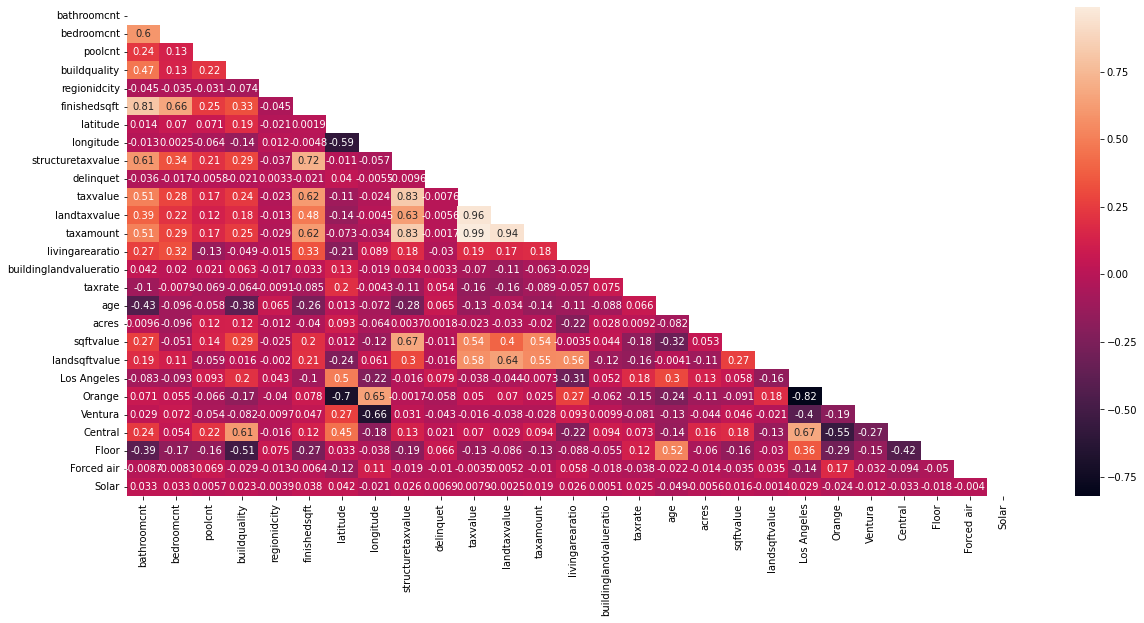

In [ ]:
df = X_train.iloc[:,:28]
#df['TARGET'] = y_train
plot_corr(df);

In [ ]:
vif_drops = ["latitude","longitude","bathroomcnt",
             "buildquality","age_bins","bedroomcnt",
             "taxrate", "taxvalue", "finishedsqft",
             "landtaxvalue", "structuretaxvalue",
             "Los Angeles"]
#vif_drops = []
df2 = df.drop(columns=vif_drops)
calc_vif(df2.iloc[:,:-1])

,variables,VIF
0,poolcnt,1.4
1,regionidcity,1.5
2,delinquet,1.0
3,taxamount,3.3
4,livingarearatio,4.3
5,buildinglandvalueratio,1.2
6,age,7.1
7,acres,1.1
8,sqftvalue,5.4
9,landsqftvalue,3.1


In [ ]:
y_train.describe()

count    50087.000000
mean         0.013576
std          0.118671
min         -1.179223
25%         -0.023706
50%          0.006492
75%          0.038125
max          1.269208
Name: logerror, dtype: float64

In [ ]:
df.describe()

,bathroomcnt,bedroomcnt,poolcnt,buildquality,regionidcity,finishedsqft,latitude,longitude,structuretaxvalue,delinquet,taxvalue,landtaxvalue,taxamount,livingarearatio,buildinglandvalueratio,taxrate,age,acres,sqftvalue,landsqftvalue,Los Angeles,Orange,Ventura,Central,Floor,Forced air,Solar
count,50087.000000,50087.000000,50087.000000,50087.000000,50087.000000,50087.000000,50087.000000,50087.000000,5.008700e+04,50087.000000,5.008700e+04,5.008700e+04,50087.000000,50087.000000,50087.000000,50087.000000,50087.000000,50087.000000,50087.000000,50087.000000,50087.000000,50087.000000,50087.000000,50087.000000,50087.000000,50087.000000,50087.000000
mean,2.263372,2.999042,0.218919,6.367680,32935.426558,1745.322139,34.006486,-118.199576,1.875554e+05,0.036237,4.856742e+05,2.981187e+05,5920.957666,0.236515,1.217349,0.013083,47.681494,0.648107,100.639937,41.194441,0.633937,0.280512,0.085551,0.439276,0.183960,0.011121,0.001418
std,0.942990,1.018359,0.413518,1.366325,46156.138628,927.282130,0.269381,0.364533,2.343219e+05,0.186881,6.283720e+05,4.532148e+05,7311.560407,0.187639,3.365589,0.004402,23.123872,2.775608,63.381177,65.266497,0.481732,0.449254,0.279703,0.496304,0.387455,0.104868,0.037624
min,0.000000,0.000000,0.000000,1.000000,0.000000,128.000000,33.339527,-119.448392,4.400000e+01,0.000000,9.242000e+03,1.196000e+03,19.920000,0.000176,0.000345,0.000141,1.000000,0.009986,0.069841,0.003805,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,2.000000,0.000000,6.000000,12447.000000,1163.000000,33.805977,-118.417864,8.355250e+04,0.000000,2.044735e+05,8.286650e+04,2683.345000,0.138959,0.413672,0.011616,30.000000,0.137741,63.193405,6.262081,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,3.000000,0.000000,6.000000,24832.000000,1507.000000,34.019300,-118.170262,1.346790e+05,0.000000,3.560000e+05,2.032750e+05,4402.300000,0.204851,0.749452,0.012256,47.000000,0.167746,91.967568,24.933689,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.000000,4.000000,0.000000,7.000000,45398.000000,2058.500000,34.177796,-117.917347,2.162015e+05,0.000000,5.644835e+05,3.660000e+05,6825.950000,0.289315,1.500055,0.013396,63.000000,0.249529,124.881110,51.323748,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,13.000000,11.000000,1.000000,12.000000,396556.000000,21929.000000,34.818767,-117.554636,1.142179e+07,1.000000,2.538125e+07,2.233550e+07,290998.060000,3.977011,612.233361,0.452884,139.000000,160.032369,2330.977551,1882.546201,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
#le = log(pred) - log(real)
df['zestimate'] = np.round(np.exp(y_train + np.log(X_train.taxvalue)))
df['actual'] = X_train.taxvalue
df['rmse'] = df.zestimate - df.actual
df['abs_logerror'] = abs(y_train)

In [ ]:
df.rmse.describe()

count    5.008700e+04
mean     1.071663e+04
std      1.668162e+05
min     -1.232512e+07
25%     -6.812500e+03
50%      1.644000e+03
75%      1.343200e+04
max      1.560847e+07
Name: rmse, dtype: float64

In [ ]:
#MAPE
abs(df.rmse).mean() / df.actual.mean()

0.0708268547670997

In [ ]:
#top 5 worst predictions
df.sort_values(by="abs_logerror", ascending=False).head().T

parcelid,14018500,12043026,14624279,10895150,12333874
bathroomcnt,2.000000,1.000000,1.000000,2.000000e+00,1.000000e+00
bedroomcnt,3.000000,1.000000,1.000000,3.000000e+00,2.000000e+00
poolcnt,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00
buildquality,6.000000,5.000000,6.000000,6.000000e+00,4.000000e+00
regionidcity,33252.000000,45457.000000,47568.000000,1.244700e+04,4.406000e+03
finishedsqft,1272.000000,756.000000,675.000000,1.302000e+03,8.630000e+02
latitude,33.790420,34.226177,33.754411,3.416797e+01,3.392947e+01
longitude,-117.894876,-118.251786,-117.840433,-1.184262e+02,-1.181264e+02
structuretaxvalue,41528.000000,15717.000000,52762.000000,1.701020e+05,1.441650e+05
delinquet,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00


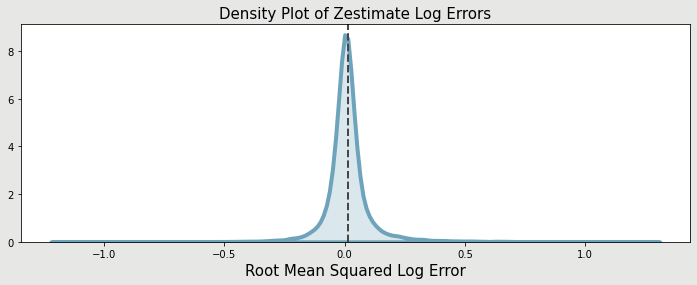

In [ ]:
f=plt.figure(figsize=(12, 4))
sns.kdeplot(y_train, linewidth=4, fill=True)
f.set_facecolor(lucario[3])
plt.axvline(y_train.mean(), color=lucario[2],
            linestyle='dashed', linewidth=2)
plt.ylabel("")
plt.xlabel("Root Mean Squared Log Error", fontsize=15)
plt.title("Density Plot of Zestimate Log Errors", fontsize=15)
#plt.text(0.2, 5, f'$\mu$=.02\nMAPE=4%', fontsize=15)
#plt.text(-3.5, .5, f'Lowest:\n$log(3400) - log(360000)$', fontsize=12)
#plt.text(1.3, .5, f'Highest:\n$log(1.3B) - log(6.6M)$', fontsize=12)
plt.show()

In [ ]:
f=plt.figure(figsize=(15, 2.5))
sns.scatterplot(data=df, y="poolcnt", x="TARGET", s=200)
plt.yticks([0,1])
plt.title("Pools are a good feature.", fontsize=15);

ValueError: ignored

<Figure size 1080x180 with 0 Axes>

## why this task is almost impossible

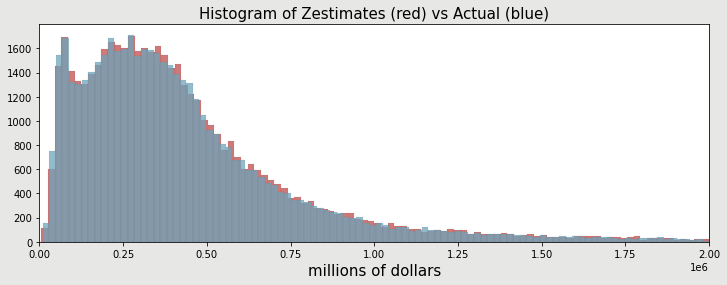

In [ ]:
f=plt.figure(figsize=(12, 4))
sns.histplot(df.zestimate, color=lucario[1])
sns.histplot(df.actual)
f.set_facecolor(lucario[3])
plt.xlim(0,2e6)
plt.ylabel("")
plt.xlabel("millions of dollars", fontsize=15)
plt.title("Histogram of Zestimates (red) vs Actual (blue)", fontsize=15)
plt.show()

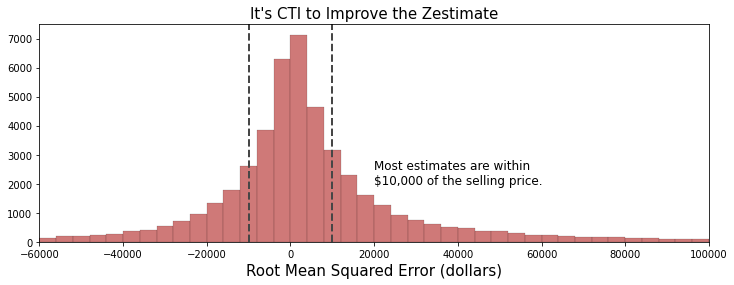

In [ ]:
f=plt.figure(figsize=(12, 4))
sns.histplot(df.rmse.clip(-1e6,1e6), color=lucario[1], bins=500)
plt.xlim(-60000, 100000)
plt.ylabel("")
plt.xlabel("Root Mean Squared Error (dollars)", fontsize=15)
plt.title("It's CTI to Improve the Zestimate", fontsize=15)
plt.axvline(-10000, color=lucario[2], linestyle='dashed', linewidth=2)
plt.axvline(10000, color=lucario[2], linestyle='dashed', linewidth=2)
plt.text(20000, 2000, f'Most estimates are within\n$10,000 of the selling price.', fontsize=12)
plt.show()

## Hypotheses

In [ ]:
#scs.f_oneway()county errors

## Mean Model

In [ ]:
#constant baseline
best_const = np.round(np.expm1(y_train.mean()),2)

#rmse/mape of logerror mean
y_pred = np.zeros(len(y_train))+best_const
mape_train = mean_absolute_percentage_error(y_train, y_pred)
rmse_train = mean_squared_error(y_train, y_pred, squared=False)

y_pred = np.zeros(len(y_val))+best_const
mape_val = mean_absolute_percentage_error(y_val, y_pred)
rmse_val = mean_squared_error(y_val, y_pred, squared=False)
r2_baseline = r2_score(y_val, y_pred)

print(f"RMSE/MAPE using Mean {best_const}:\n  Train/In-Sample: {round(rmse_train, 4), round(mape_train, 1)*100}", 
      f"\n  Validate/Out-of-Sample: {round(rmse_val, 4), round(mape_val, 1)*100}")

RMSE/MAPE using Mean 0.01:
  Train/In-Sample: (0.1187, 260.0) 
  Validate/Out-of-Sample: (0.1173, 240.0)


## A Cluster a Day


Missing values in ['delinquet', 'poolcnt', 'heating', 'regionidcity'] replaced with zeros

Missing values in ['buildquality', 'lotsqft'] replaced with median

These columns were dropped.
Empty DataFrame
Columns: [missing count, missing %]
Index: []

353 incomplete cases dropped from the data.

215 outliers dropped based on ['logerror'].

X_train (50087, 99), X_test (10734, 99), X_val (10733, 99)
y_train (50087,), y_test (10734,), y_val (10733,)


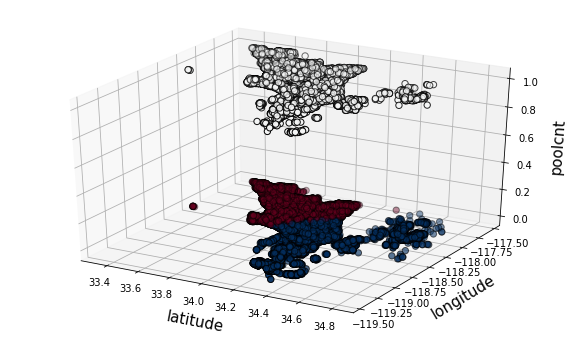

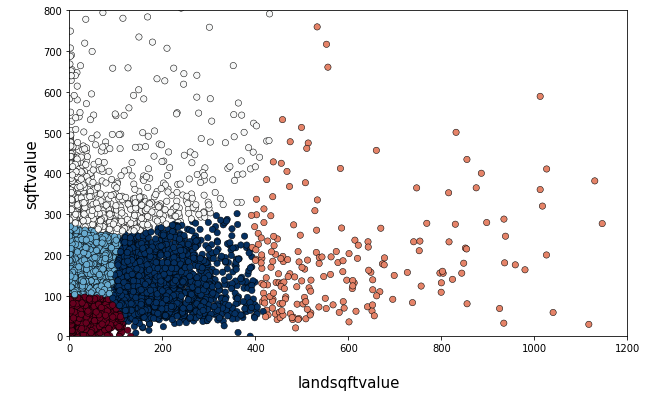

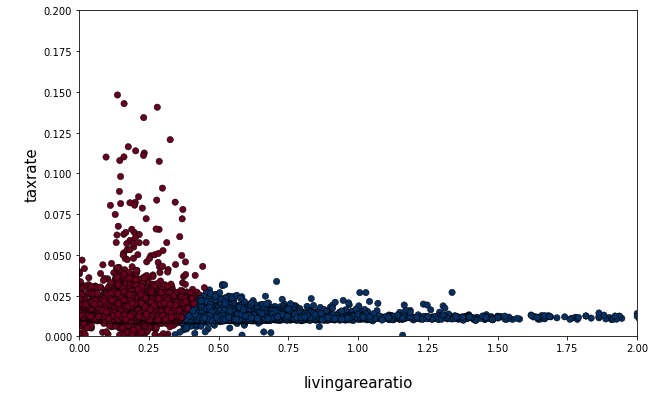

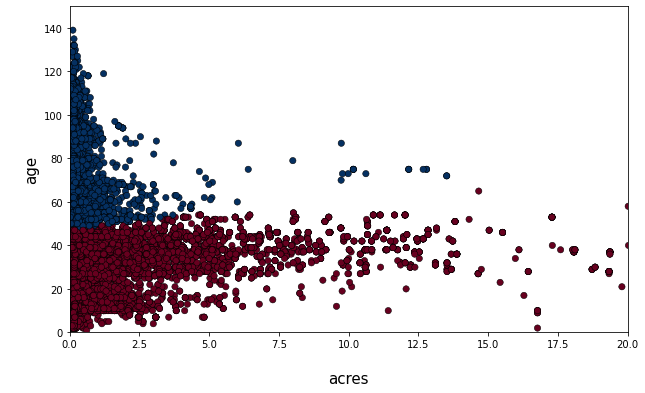

In [ ]:
X_train, X_test, X_val, y_train, y_test, y_val = wrangle_zillow(test_size=.15, k=20)

clusters = [
            [[3],["latitude", "longitude", "poolcnt"]],
            #[[3],["delinquet", "longitude", "latitude"]],
            [[5, 1200, 800],["landsqftvalue", "sqftvalue"]],
            [[2, 2, .2],["livingarearatio", "taxrate"]],
            [[2, 20, 150],["acres", "age"]]
            ]
            #

for idx, X in enumerate(clusters):

  k = X[0][0]

  kmeans = make_pipeline(StandardScaler(), KMeans(n_clusters=k))
  dbscan = make_pipeline(StandardScaler(), DBSCAN())

  X_train[f'CLUSTER{idx}'] = kmeans.fit_predict(X_train[X[1]])
  X_val[f'CLUSTER{idx}'] = kmeans.fit_predict(X_val[X[1]])
  X_test[f'CLUSTER{idx}'] = kmeans.fit_predict(X_test[X[1]])

  f = plt.figure(figsize=(10, 6))

  if len(X[1]) == 3:
    ax = f.add_subplot(111, projection='3d')
    x = np.array(X_train[X[1][0]])
    y = np.array(X_train[X[1][1]])
    z = np.array(X_train[X[1][2]])
    ax.scatter(x,y,z, marker='o', edgecolor='k',
               c=X_train[f'CLUSTER{idx}'], s=40, cmap='RdBu')

    ax.set_xlabel('\n'+X[1][0], fontsize=15)
    ax.set_ylabel('\n'+X[1][1], fontsize=15)
    ax.set_zlabel('\n'+X[1][2], fontsize=15)

  if len(X[1]) == 2:
    x = np.array(X_train[X[1][0]])
    y = np.array(X_train[X[1][1]])
    plt.ylim(0,X[0][2])
    plt.xlim(0,X[0][1])
    sns.scatterplot(x,y, marker='o', edgecolor='k',
                    c=X_train[f'CLUSTER{idx}'], s=40, cmap='RdBu')

    plt.xlabel('\n'+X[1][0], fontsize=15)
    plt.ylabel('\n'+X[1][1], fontsize=15)

  plt.show()

  X_train = pd.concat([X_train,
                       pd.get_dummies(X_train[f'CLUSTER{idx}'],
                                      prefix=X[1][0]+"_"+X[1][1],
                                      drop_first=True)], axis=1)
  X_val = pd.concat([X_val,
                     pd.get_dummies(X_val[f'CLUSTER{idx}'],
                                      prefix=X[1][0]+"_"+X[1][1],
                                      drop_first=True)], axis=1)
  X_test = pd.concat([X_test,
                      pd.get_dummies(X_test[f'CLUSTER{idx}'],
                                      prefix=X[1][0]+"_"+X[1][1],
                                      drop_first=True)], axis=1)
  
  X_train.drop(f'CLUSTER{idx}', axis=1, inplace=True)
  X_val.drop(f'CLUSTER{idx}', axis=1, inplace=True)
  X_test.drop(f'CLUSTER{idx}', axis=1, inplace=True)

  

In [ ]:
X_train.head()

,bathroomcnt,bedroomcnt,poolcnt,buildquality,regionidcity,finishedsqft,latitude,longitude,structuretaxvalue,delinquet,taxvalue,landtaxvalue,taxamount,livingarearatio,buildinglandvalueratio,taxrate,age,age_bins,acres,sqftvalue,landsqftvalue,Los Angeles,Orange,Ventura,Central,Floor,Forced air,Solar,95984.0,95989.0,96006.0,96007.0,96020.0,96022.0,96026.0,96038.0,96043.0,96046.0,96047.0,96049.0,...,96326.0,96336.0,96338.0,96339.0,96342.0,96368.0,96379.0,96387.0,96415.0,96426.0,96437.0,96465.0,96467.0,96475.0,96492.0,96508.0,96513.0,96517.0,96939.0,96946.0,96951.0,96962.0,96975.0,96981.0,96985.0,97018.0,97023.0,97026.0,97068.0,97111.0,97113.0,97298.0,latitude_longitude_1,latitude_longitude_2,landsqftvalue_sqftvalue_1,landsqftvalue_sqftvalue_2,landsqftvalue_sqftvalue_3,landsqftvalue_sqftvalue_4,livingarearatio_taxrate_1,acres_age_1
parcelid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12566099,1.0,3.0,0.0,4.0,46298.0,1015.0,33.868232,-118.196184,84468.0,0.0,345184.0,260716.0,4249.92,0.156130,0.323985,0.012312,73.0,1,0.149242,83.219704,40.103984,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
14471109,3.0,3.0,0.0,6.0,12773.0,2340.0,33.575620,-117.645998,247679.0,0.0,404651.0,156972.0,4009.14,0.468000,1.577855,0.009908,27.0,0,0.114784,105.845726,31.394400,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
12322197,1.0,2.0,0.0,4.0,47762.0,862.0,33.914780,-118.169196,94855.0,0.0,254647.0,159792.0,3598.17,0.135962,0.593615,0.014130,69.0,1,0.145546,110.040603,25.203785,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
14116975,2.0,3.0,0.0,6.0,16764.0,1309.0,33.821076,-117.885153,60964.0,0.0,331043.0,270079.0,3972.00,0.170000,0.225727,0.011998,58.0,1,0.176768,46.572956,35.075195,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
12069058,1.0,2.0,0.0,4.0,45457.0,1237.0,34.149297,-118.240549,124490.0,0.0,622468.0,497978.0,6771.20,0.158366,0.249991,0.010878,95.0,1,0.179316,100.638642,63.753425,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1


## Feature Selection

In [ ]:
select = SelectKBest(f_regression, k=5)
select.fit_transform(X_train, y_train)
filter = select.get_support()
top_features = pd.Series(X_train.columns[filter])

final_features = []
for x in top_features:
  if x not in vif_drops:
    final_features.append(x)
final_features

['sqftvalue', 96951.0]

In [ ]:
X_train_final = X_train[final_features]
X_val_final = X_val[final_features]
X_test_final = X_test[final_features]

lm1 = make_pipeline(StandardScaler(), LinearRegression())
lm2 = make_pipeline(StandardScaler(), LassoLars())
lm3 = make_pipeline(StandardScaler(), TweedieRegressor())
lm4 = make_pipeline(StandardScaler(), PolynomialFeatures(), LinearRegression())

#change this line to try different models
model = lm1

model.fit(X_train_final, y_train)
y_pred_train = model.predict(X_train_final)
y_pred_val = model.predict(X_val_final)

#rmse/mape of linear model
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)

mape_val = mean_absolute_percentage_error(y_val, y_pred_val)
rmse_val = mean_squared_error(y_val, y_pred_val, squared=False)
r2_baseline = r2_score(y_val, y_pred_val)

print(f"RMSE/MAPE using Linear Model:\n  Train/In-Sample: {round(rmse_train, 4), round(mape_train, 1)*100}", 
      f"\n  Validate/Out-of-Sample: {round(rmse_val, 4), round(mape_val, 1)*100}")

RMSE/MAPE using Linear Model:
  Train/In-Sample: (0.1185, 330.0) 
  Validate/Out-of-Sample: (0.1171, 290.0)


## Evaluation a 0.25% difference

Despite its complexity, the best linear model isn't significantly outperforming the default model of predicting the mean error for every observation. The residuals don't indicate that the model is picking up on any signal within the error terms; variation is meaningless noise.

In [ ]:
y_pred_test = model.predict(X_test_final)

mape_lm = mean_absolute_percentage_error(y_test, y_pred_test)
rmse_lm = mean_squared_error(y_test, y_pred_test, squared=False)

mape_mean = mean_absolute_percentage_error(y_test, np.zeros(len(y_test))+best_const)
rmse_mean = mean_squared_error(y_test, np.zeros(len(y_test))+best_const, squared=False)

print(f"RMSE/MAPE using Linear Model on test: {round(rmse_lm, 4), round(mape_lm, 1)*100}", 
      f"\nRMSE/MAPE using Mean Model on test: {round(rmse_mean, 4), round(mape_mean, 1)*100}")

RMSE/MAPE using Linear Model on test: (0.1137, 270.0) 
RMSE/MAPE using Mean Model on test: (0.1138, 220.00000000000003)


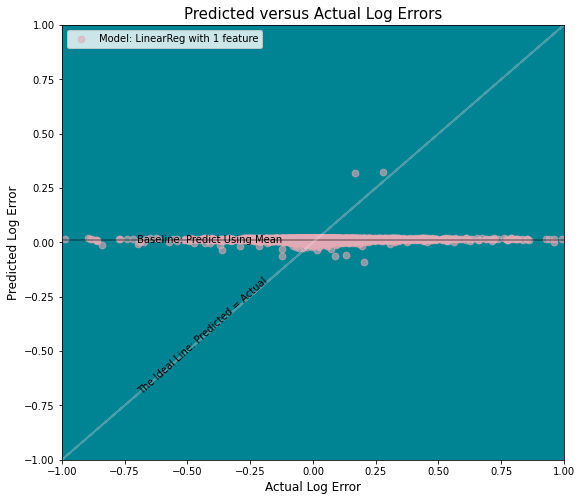

In [ ]:
f, ax = plt.subplots(figsize=(9,8))
ax.set_facecolor(puff[0])

alpha_line, alpha_scatter, scatter_size = .3, .6, 45
rotation = 42
limit = -1.
scatter_color = puff[1]

plt.plot(y_test, np.zeros(len(y_test))+best_const, alpha=alpha_line,
         color="black", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (-.7, 0))
plt.plot(y_test, y_test, alpha=alpha_line, color=puff[3], label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (-.7, -.7), rotation=rotation)
plt.scatter(y_test, model.predict(X_test_final), alpha=alpha_scatter,
            color=scatter_color, s=scatter_size, label="Model: LinearReg with 1 feature")
plt.legend()
plt.xlabel("Actual Log Error", fontsize=12)
plt.ylabel("Predicted Log Error", fontsize=12)
plt.xlim(limit, abs(limit))
plt.ylim(limit, abs(limit))
plt.title("Predicted versus Actual Log Errors", fontsize=15)
#plt.savefig("img/preds.png")
plt.show()

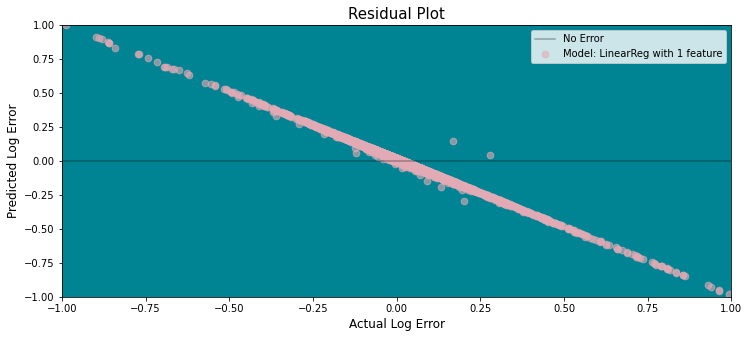

In [ ]:
f, ax = plt.subplots(figsize=(12,5))
ax.set_facecolor(puff[0])

plt.axhline(label="No Error", color="black", alpha=alpha_line)
plt.scatter(y_test, model.predict(X_test_final) - y_test, alpha=alpha_scatter,
            color=scatter_color, s=scatter_size, label="Model: LinearReg with 1 feature")
plt.legend()
plt.xlabel("Actual Log Error", fontsize=12)
plt.ylabel("Predicted Log Error", fontsize=12)
plt.xlim(limit, abs(limit))
plt.ylim(limit, abs(limit))
plt.title("Residual Plot", fontsize=15)
#plt.savefig("img/resid.png")
plt.show()

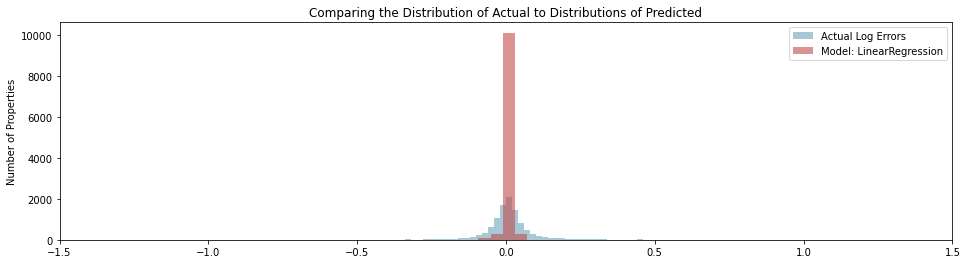

In [ ]:
plt.figure(figsize=(16,4))
plt.hist(y_test.clip(-1,1), alpha=alpha_scatter, label="Actual Log Errors", bins=100)
plt.hist(model.predict(X_test_final), alpha=alpha_scatter, label="Model: LinearRegression")
plt.xlabel("")
plt.xlim(-1.5,1.5)
plt.ylabel("Number of Properties")
plt.title("Comparing the Distribution of Actual to Distributions of Predicted")
plt.legend()
plt.show()

Error is greatest for the homes that are 50-80 years old. Error is greatest for the properties sitting on smaller land. Error is greatest for properties with fewer square feet. Error is greatest for properties with 1 or 2 bathrooms. Error is greatest for locations in the southern to center (S-N) of the county. Error is greatest for locations in the center (W-E) of the county as opposed to on the coastline or far eastern edge. Error is greatest and positive for the lower structure dollar per square feet, indicating the properties tax value is underrepresenting the future sale price. Error is greatest the the lower and more common tax rates. Error is greatest for homes where the number of bathrooms <= number of bedrooms. 


Recommendations:
Searching for predicatble patterns in the model's errors would reveal potential new features, however, the model is already excellent. There is a level of unknowable, systemic error in price predictions because buyers are not perfectly rational beings. It's unlikely that the existing features can be used to improve predictions.